In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Define the class names in the same order as they were during training
class_names = ["checkered", "dotted", "floral", "solid", "striped", "zig_zag"]

# The transforms for inference (no augmentation) must match the validation transforms
inference_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Re-create the AlexNet model with the correct classifier layer
alexnet = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))

# Load the saved state dictionary
model_path = 'alexnet_pattern_model.pth' # <-- EDIT THIS WITH YOUR SAVED MODEL PATH
alexnet.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
alexnet.eval()
alexnet = alexnet.to(device)

In [2]:
def predict_image(model, image_path, transforms, class_names, device):
    # Load the image using PIL
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess the image
    image_tensor = transforms(image).unsqueeze(0).to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_class_idx = torch.max(probabilities, 1)
        predicted_class = class_names[predicted_class_idx.item()]
        
    return predicted_class, probabilities.cpu().numpy()

Image: 001.jpg
Predicted Class: solid
Probabilities: [9.3057849e-02 1.2536122e-03 1.6052274e-04 4.7385409e-01 4.3094316e-01
 7.3073758e-04]


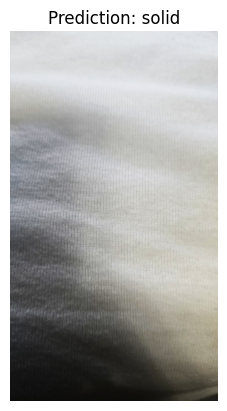

Image: 002.jpg
Predicted Class: checkered
Probabilities: [0.30629978 0.11877511 0.0409794  0.23641452 0.15945481 0.13807641]


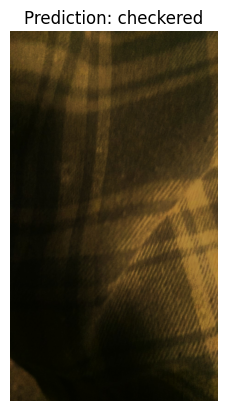

Image: 003.jpg
Predicted Class: floral
Probabilities: [0.15646999 0.01017704 0.7006629  0.01050953 0.04333944 0.07884106]


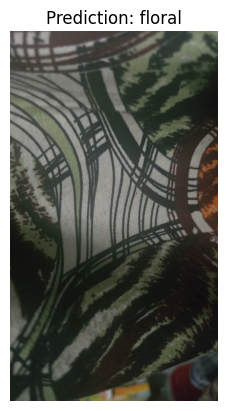

Image: 004.jpg
Predicted Class: striped
Probabilities: [0.02155986 0.00247684 0.00218679 0.06365459 0.90679127 0.00333076]


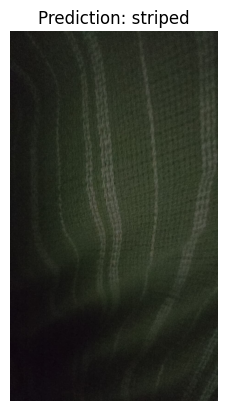

Image: 005.jpg
Predicted Class: solid
Probabilities: [2.6331656e-04 2.9851453e-04 2.9541852e-04 9.8156548e-01 1.7047893e-02
 5.2937772e-04]


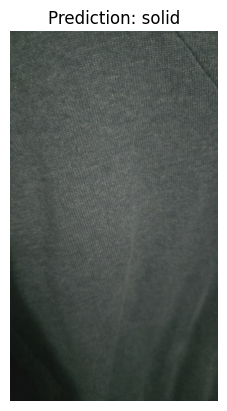

In [5]:
# Path to your test images folder
test_images_folder = Path('my_test_images/') # <-- EDIT THIS PATH

# Get all image files in the folder
image_files = [f for f in test_images_folder.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

if not image_files:
    print("No images found in the test folder.")
else:
    for image_path in image_files:
        predicted_class, probabilities = predict_image(
            alexnet,
            str(image_path),
            inference_transforms,
            class_names,
            device
        )

        print(f"Image: {image_path.name}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Probabilities: {probabilities.flatten()}")
        
        # Display the image with the prediction title
        img_display = Image.open(image_path)
        plt.imshow(img_display)
        plt.title(f"Prediction: {predicted_class}")
        plt.axis('off')
        plt.show()